In [224]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from IPython import display
from IPython.core.display import display as disp, HTML
disp(HTML("<style>.container { width:100% !important; }</style>"))

In [309]:
# Setup the sensor geometry
# All units in mm

sensor = {
    'px': .1e-3*1,
    'npix':[1024//1, 1024//1]
    }

sensor['fov'] = [sensor['npix'][0]*sensor['px'], sensor['npix'][1]*sensor['px']]


In [301]:
sensor['fov']

[0.10200000000000001, 0.10200000000000001]

In [302]:
def genz(ii, rhomax):
    if ii == 1:
        Z = lambda x, y : np.ones_like(x)
        fx = lambda x, y : 0
        fy = lambda x, y : 0
    elif ii == 2:
        Z = lambda x, y : x/rhomax
        fx = lambda x, y : 1/rhomax
        fy = lambda x, y : 0
    elif ii == 3:
        Z = lambda x, y : y/rhomax
        fx = lambda x, y : 0
        fy = lambda x, y : 1/rhomax    
    elif ii == 4:
        Z = lambda x, y : (x/rhomax)**2 - (y/rhomax)**2
        fx = lambda x, y : 2*x/(rhomax**2)
        fy = lambda x, y : -2*y/(rhomax**2)
    elif ii == 5:
        Z = lambda x, y : -1 + 2*(x/rhomax)**2 + 2*(y/rhomax)**2
        fx = lambda x, y : 4*x/(rhomax**2)
        fy = lambda x, y : 4*y/(rhomax**2)
    elif ii == 6:
        Z = lambda x, y : 2*x*y/(rhomax**2)
        fx = lambda x, y : 2*y/(rhomax**2)
        fy = lambda x, y : 2*x/(rhomax**2)
    elif ii == 7:
        Z = lambda x, y : (x/rhomax)**3 - 3*(x/rhomax)*(y/rhomax)**2
        fx = lambda x, y : 3*x**2/(rhomax**3) - 3*y**2/(rhomax**3)
        fy = lambda x, y : 6*x*y/(rhomax**3)
    elif ii == 8:
        Z = lambda x, y : 3*(x/rhomax)**3 + 3*(x/rhomax)*(y/rhomax)**2 - 2*x/rhomax
        fx = lambda x, y : 9*x**2/(rhomax**3) + 3*y**2/(rhomax**3) - 2/rhomax
        fy = lambda x, y : 6*x*y/(rhomax**3)
    elif ii == 9:
        Z = lambda x, y : 3*(y/rhomax)**3 + 3*(x/rhomax)**2*(y/rhomax) - 2*y/rhomax
        fx = lambda x, y : 6*x*y/(rhomax**3)
        fy = lambda x, y : 9*y**2/(rhomax**3) + 3*x**2/(rhomax**3) - 2/rhomax
    elif ii == 10:
        Z = lambda x, y : -(y/rhomax)**3 + 3*(x/rhomax)**2*y/rhomax
        fx = lambda x, y : 6*x*y/(rhomax**3)
        fy = lambda x, y : -3*y**2/(rhomax**3) + 3*x**2/(rhomax**3)
    return Z, fx, fy

In [303]:
def genW2(zlist, coeffs, rhomax):
    zern = []    
    for ii in range(len(zlist)):
        zern.append(genz(zlist[ii],rhomax))

    W = lambda x,y:sum([zern[ii][0](x,y)*coeffs[ii] for ii in range(len(zlist))])
    fx = lambda x,y:sum([zern[ii][1](x,y)*coeffs[ii] for ii in range(len(zlist))])
    fy = lambda x,y:sum([zern[ii][2](x,y)*coeffs[ii] for ii in range(len(zlist))])
    return W, fx, fy

In [290]:
def genW(zlist,coeffs,rhomax):
    W = lambda x,y:sum([genz(zlist[ii],rhomax)[0](x,y)*coeffs[ii] for ii in range(len(zlist))])
    fx = lambda x,y:sum([genz(zlist[ii],rhomax)[1](x,y)*coeffs[ii] for ii in range(len(zlist))])
    fy = lambda x,y:sum([genz(zlist[ii],rhomax)[2](x,y)*coeffs[ii] for ii in range(len(zlist))])
    return W, fx, fy

In [194]:
def genSin(wx,wy,amp):
    W = lambda x,y:amp*(np.sin(wx*x) + np.sin(wy*y))
    fx = lambda x,y:amp*wx*np.cos(wx*x)
    fy = lambda x,y:amp*wy*np.cos(wy*y)
    return W, fx, fy

In [195]:
# Test the generation of wavefronts using zernikes
rx = np.linspace(-sensor['fov'][1]/2,sensor['fov'][1]/2,sensor['npix'][1]);
ry = np.linspace(-sensor['fov'][0]/2,sensor['fov'][0]/2,sensor['npix'][0]);

[Rx,Ry] = np.meshgrid(rx,ry)

zlist = 1+np.r_[1:10]
zco = np.random.randn(len(zlist))



In [196]:
def genSph(efl):
    # Create function handles for spherical wavefront
    # and derivatives, fx and fy.
    # The curvature is designed so that it focuses at a deistance efl
    Wsph = lambda x,y : efl - efl*np.real(np.sqrt(1 - (x/efl)**2 - (y/efl)**2 + 0j))
    #fx = lambda x,y: x/np.sqrt(1 - (x/efl)**2 - (y/efl)**2)/efl
    #fy = lambda x,y: y/np.sqrt(1 - (x/efl)**2 - (y/efl)**2)/efl
    fx = lambda x,y: x/(efl * np.sqrt(1 - (y/efl)**2 - (x/efl)**2))
    fy = lambda x,y: y/(efl * np.sqrt(1 - (y/efl)**2 - (x/efl)**2))
    return Wsph, fx, fy


In [197]:
# Construct a wavefront as a surface
# genW creates a list. 0 holds the wavefront, 
# 1 is the x derivative and 2 is the y derivative
zlist = np.r_[1:11]
print(zlist)
zco = .001*np.random.randn(len(zlist))
zco[0] = 0
zco[1] = .00
zco[2] = .00
zco[zlist==5] = 0.
wx = 100
wy = 50
amp = .000
lam = 550e-6
# rhomax = pupil['ca'][0]/2
# Wtest, fx, fy = genW2(zlist,zco,rhomax)




[ 1  2  3  4  5  6  7  8  9 10]


In [198]:
zco

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.37799272e-03,
        0.00000000e+00, -1.33184701e-03, -2.34878994e-04, -1.29013130e-03,
       -4.71576589e-05,  1.07389593e-05])

In [199]:
pupil = {
    'ca':[.5, .5],
    'efl' : 1,
    't': 1,
    'ap_type' : 'circ'
}

rhomax = pupil['ca'][0]/2
         
W = genW2(zlist, zco, rhomax)
pupil['W_aber'] = W[0]
pupil['fx_aber'] = W[1]
pupil['fy_aber'] = W[2]

W_sph = genSph(pupil['efl']);
pupil['W_sph'] = W_sph[0]
pupil['fx_sph'] = W_sph[1]
pupil['fy_sph'] = W_sph[2]

W_sin = genSin(wx,wy,amp)
pupil['W_sin'] = W_sin[0]
pupil['fx_sin'] = W_sin[1]
pupil['fy_sin'] = W_sin[2]

In [254]:
Rx

array([[-0.2556    , -0.25549998, -0.25539996, ...,  0.25539996,
         0.25549998,  0.2556    ],
       [-0.2556    , -0.25549998, -0.25539996, ...,  0.25539996,
         0.25549998,  0.2556    ],
       [-0.2556    , -0.25549998, -0.25539996, ...,  0.25539996,
         0.25549998,  0.2556    ],
       ...,
       [-0.2556    , -0.25549998, -0.25539996, ...,  0.25539996,
         0.25549998,  0.2556    ],
       [-0.2556    , -0.25549998, -0.25539996, ...,  0.25539996,
         0.25549998,  0.2556    ],
       [-0.2556    , -0.25549998, -0.25539996, ...,  0.25539996,
         0.25549998,  0.2556    ]])

In [260]:
W[0]

array([0.07014867, 0.07011794, 0.07008723, ..., 0.06540813, 0.06543015,
       0.06545218])

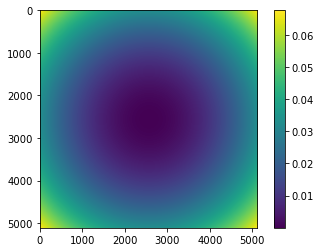

In [263]:
W = genW2(zlist, zco, rhomax)
pupil['W_aber'] = W[0]
pupil['fx_aber'] = W[1]
pupil['fy_aber'] = W[2]
plt.figure()
plt.imshow(W_sph[0](Rx,Ry))
plt.colorbar()

In [269]:
pupil['ca']

[0.5, 0.5]

In [270]:
res = 1.22*lam*pupil['efl']/pupil['ca'][0]
print(res)

0.001342


In [271]:
# Make a function that can compute a ray's position and OPD at the sensor
def trace_ray(rhox, rhoy, pupil,debug=False):
    W = pupil['W_sph'](rhox,rhoy) + pupil['W_aber'](rhox,rhoy) + pupil['W_sin'](rhox,rhoy)
    fx = pupil['fx_sph'](rhox,rhoy) + pupil['fx_aber'](rhox,rhoy) + pupil['fx_sin'](rhox,rhoy)
    fy = pupil['fy_sph'](rhox,rhoy) + pupil['fy_aber'](rhox,rhoy) + pupil['fy_sin'](rhox,rhoy)
    z0 = W - pupil['t']
    nlength = np.sqrt(1 + fx**2 + fy**2)
    K = -fx/nlength
    L = -fy/nlength
    M = 1/nlength
    dz = -z0    
    Delta = dz/M

    
    
    #dy = -dz*fy
    #dx = -dz*fx

    dx = K*Delta
    dy = L*Delta
    
    yo = rhoy + dy
    xo = rhox + dx;
    if debug:
        print('(rhox, rhoy):',rhox,rhoy)
        print('(Fx,Fy)',fx,fy)
        print('(dx, dy, dz)=',dx,dy,dz)        
        print('(xo,yo,zo)',xo,yo,z0)
        print('(K,L,M)=',K,L,M)
        print('Delta:', Delta)
        print('\n')

    
    opl = Delta
    return xo, yo, opl, W, fx, fy, K, L, M

In [272]:
# Rays-only loop
Nrays = 50000
xo = []
yo = []
opl = []
for k in range(Nrays):
    
    
    # Pick a random location on the surface
    if pupil['ap_type'] == 'circ':
        thx = np.random.rand(1)*2*np.pi
        rho = pupil['ca'][0]/2*np.sqrt(np.random.rand(1))
        rhox = rho*np.sin(thx)
        rhoy = rho*np.cos(thx)
    elif pupil['ap_type'] == 'rect':
        rhox = pupil['ca'][1]*(np.random.rand(1) - 0.5)
        rhoy = pupil['ca'][0]*(np.random.rand(1) - 0.5)

    

    # Launch a ray toward the sensor
    rays_out = trace_ray(rhox, rhoy, pupil,debug=False)
    xo.append(rays_out[0])
    yo.append(rays_out[1])
    opl.append(rays_out[2])

    # Create the corresponding plane wave on the sensor grid

    # Add this plane wave to the existing distribution

    # Repeat



In [273]:
#a,b,c,Wt,Fxt,Fyt = trace_ray(Rx,Ry,pupil)

(-0.016137031461626372,
 0.05153406155619747,
 -0.03394570960126834,
 0.02311694945855334)

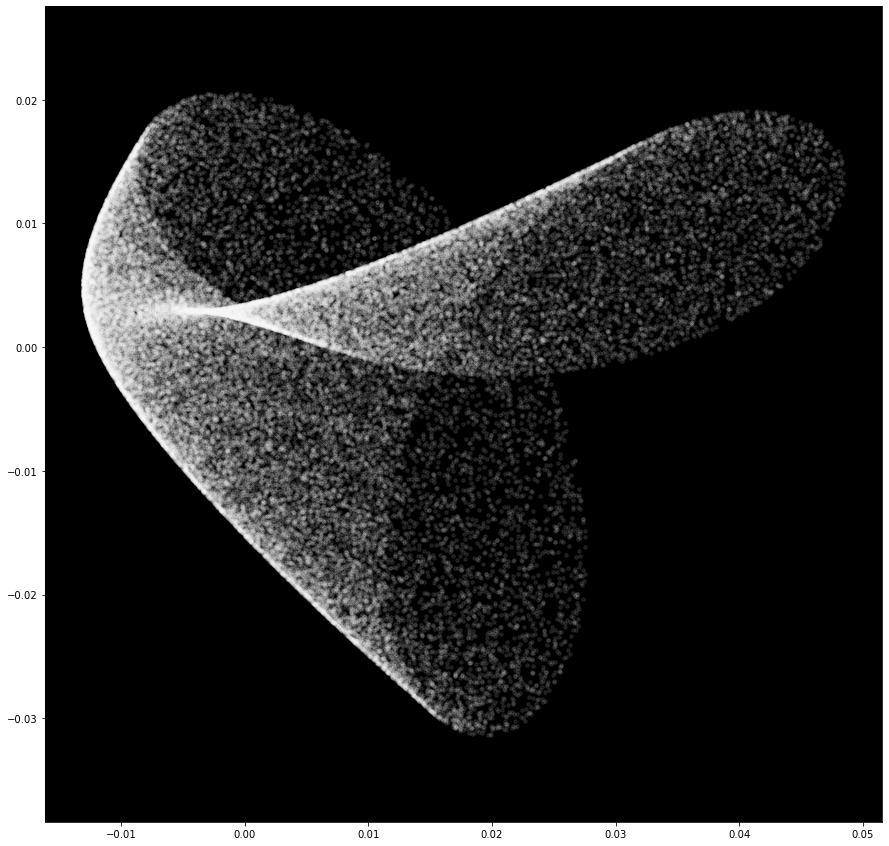

In [274]:
f = plt.figure(figsize=(15,15))
ax = plt.gca()
ax.set_facecolor((0,0,0))
plt.scatter(xo,yo,s=50,c=[[1, 1, 1]],marker='.',alpha=.1)
ax.axis('equal')

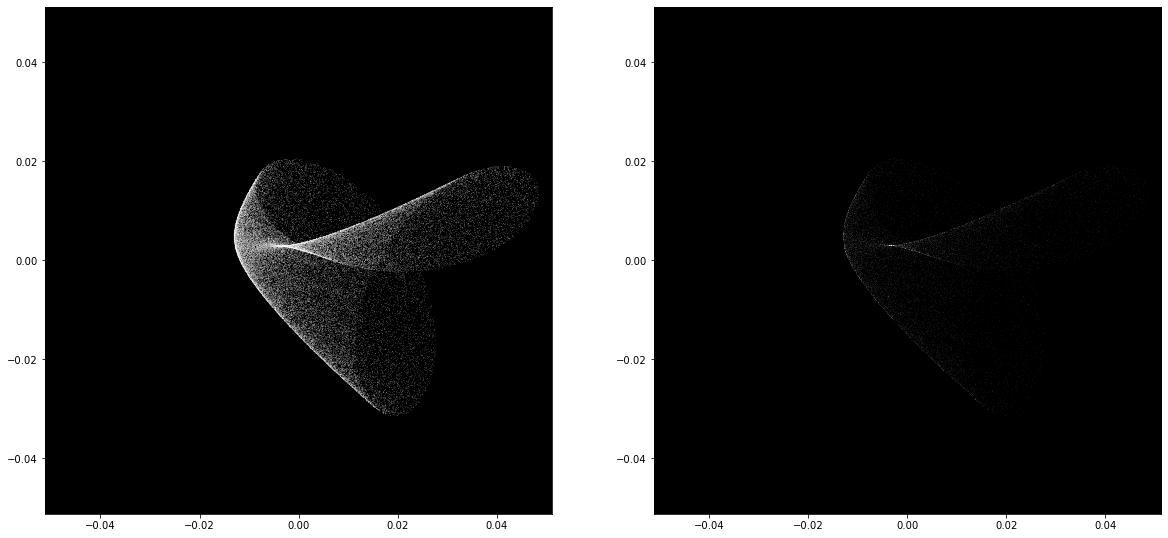

In [311]:
#bins = sensor['npix'],range=sensor['fov']
#sensor['px']=.05
yoarr = np.asarray(yo)[:,0]
xoarr = np.asarray(xo)[:,0]
binedgex = np.r_[:sensor['npix'][1]+1]*sensor['px']
binedgex -= np.mean(binedgex)
binedgey = np.r_[:sensor['npix'][0]+1]*sensor['px']
binedgey -= np.mean(binedgey)
H,xe, ye = np.histogram2d(xoarr,yoarr,
                          bins=[sensor['npix'][1],sensor['npix'][0]],
                          range=[[-sensor['fov'][1]/2,sensor['fov'][1]/2],[-sensor['fov'][0]/2,sensor['fov'][0]/2]])
fig, ax = plt.subplots(1,2,figsize=(20,10))
figextent = [-sensor['fov'][1]/2,sensor['fov'][1]/2,-sensor['fov'][0]/2,sensor['fov'][0]/2]
ax[1].imshow(H.transpose()[::-1], extent=figextent,interpolation='none',cmap='gray')
ax[0].scatter(xo,yo,s=.01,c=[[1, 1, 1]],marker='.',alpha=1)
ax[0].set_facecolor((0,0,0))

ax[0].set(xlim=(-sensor['fov'][1]/2,sensor['fov'][1]/2),ylim=(-sensor['fov'][0]/2,sensor['fov'][0]/2))
ax[0].set_aspect('equal', adjustable='box')

In [208]:
def ray2wave(xo,yo,fx,fy,opl,lamb,sensor, Sx, Sy):
    k = 2*np.pi/lamb
    opd = k*opl
    nnorm = np.sqrt(fx**2 + fy**2 + 1)
    kx = -fx*k/nnorm
    ky = -fy*k/nnorm
#    kz = np.sqrt(k**2 - kx**2 - ky **2)

    
    U = np.exp(1j*(-kx*(Sx-xo) - ky*(Sy-yo) - opd))
    return U


In [209]:
def drawnow(fig):
    display.clear_output(wait=True)
    display.display(fig)

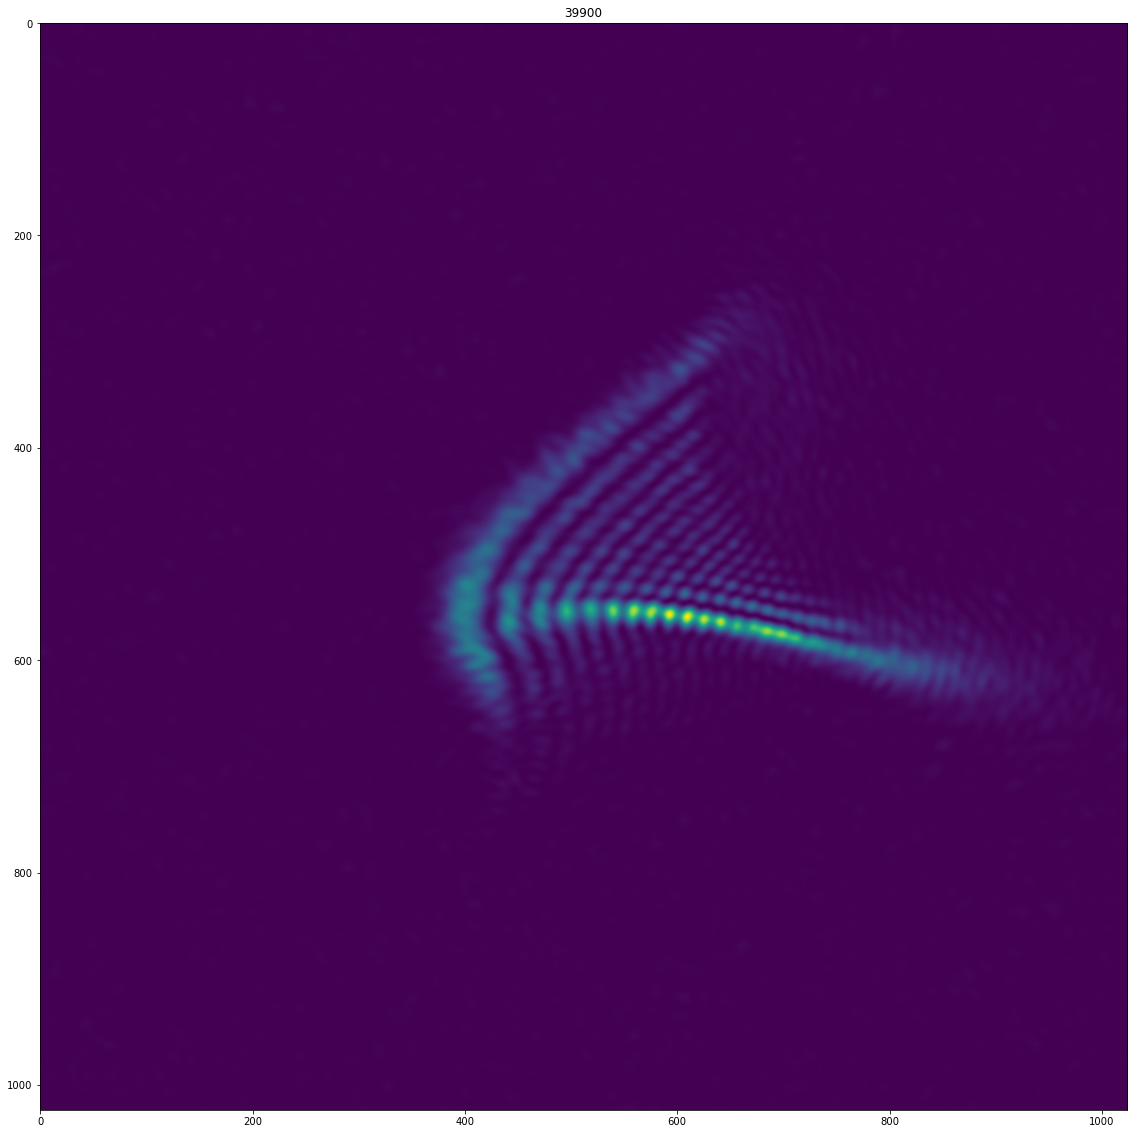

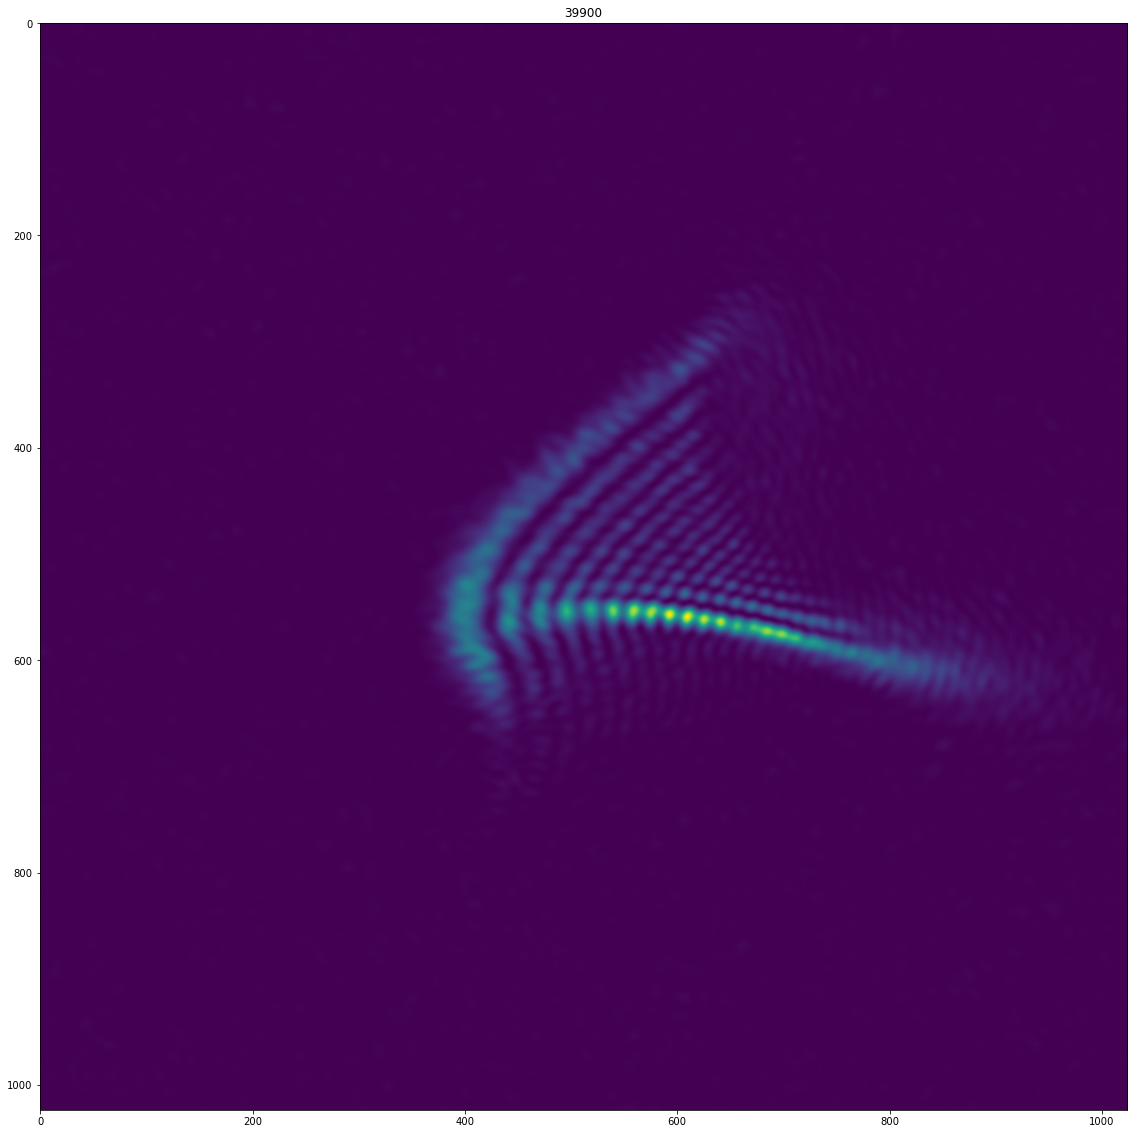

In [210]:
# Plane waves loop
Nrays = 40000
xo = []
yo = []
opl = []
fx = []
fy = []
dx = []
dy = []

U_accum = np.zeros(sensor['npix']) + 1j*np.zeros(sensor['npix'])
f = plt.figure(figsize=(20,20))
sx = np.linspace(-sensor['fov'][1]/2,sensor['fov'][1]/2,sensor['npix'][1])
sy = np.linspace(-sensor['fov'][0]/2,sensor['fov'][0]/2,sensor['npix'][0])
Sx,Sy = np.meshgrid(sx,sy)

for kk in range(Nrays):
    
    
    # Pick a random location on the surface
    if pupil['ap_type'] == 'circ':
        thx = np.random.rand(1)*2*np.pi
        rho = pupil['ca'][0]/2*np.sqrt(np.random.rand(1))
        rhox = rho*np.sin(thx)
        rhoy = rho*np.cos(thx)
    elif pupil['ap_type'] == 'rect':
        rhox = pupil['ca'][1]*(np.random.rand(1) - 0.5)
        rhoy = pupil['ca'][0]*(np.random.rand(1) - 0.5)

    # Launch a ray toward the sensor
    rays_out = trace_ray(rhox, rhoy, pupil,debug=False)
#     xo.append(rays_out[0])
#     yo.append(rays_out[1])
#     dx.append(xo[kk] - rhox)
#     dy.append(yo[kk] - rhoy)
#     opl.append(rays_out[2])
#     fx.append(rays_out[4])
#     fy.append(rays_out[5])
    xo_d = rays_out[0]
    yo_d = rays_out[1]
    fx_d = rays_out[4]
    fy_d = rays_out[5]
    opl_d = rays_out[2]
    #print(fx[kk])
    #print(fy[kk])
    #U = ray2wave(xo[kk],yo[kk],fx[kk],fy[kk],opl[kk],550e-6,sensor, Sx, Sy)
    U = ray2wave(xo_d, yo_d, fx_d, fy_d, opl_d, lam, sensor, Sx, Sy)
    
    U_accum += U
    if kk%100==0:
        plt.imshow(np.abs(U_accum)**2)#,extent=figextent)
        #plt.imshow(np.real(U))
        plt.title(kk)
        print(kk)
        drawnow(f)
    # Create the corresponding plane wave on the sensor grid

    # Add this plane wave to the existing distribution

    # Repeat

U_out = U_accum



In [216]:
# Compare to Fresnel propagation
def propagate_field(lam, ps, z, U):
    k = 2*np.pi/lam   
    siz = np.shape(U)
    fx = np.linspace(-1/2/ps,1/2/ps,siz[1])
    fy = np.linspace(-1/2/ps,1/2/ps,siz[0])
    x = np.linspace(-siz[1]/2*ps,siz[1]/2*ps,siz[1])
    y = np.linspace(-siz[0]/2*ps,siz[0]/2*ps,siz[0])
    X,Y = np.meshgrid(x,y)
    Fx,Fy = np.meshgrid(fx,fy)
    Uf = np.fft.fftshift(np.fft.fft2(U))
    Hf = np.exp(1j*2*np.pi*z/lam * np.sqrt(0j+1-(lam*Fx)**2 - (lam*Fy)**2))
    Up = np.fft.ifft2(np.fft.ifftshift(Uf*Hf))
    return Up

In [225]:
a={'a_thing':12}
b = copy.deepcopy(a)
b['a_thing']=5
a['a_thing']

12

In [234]:
sensor_FFT = copy.deepcopy(sensor)
sensor_FFT['npix']=np.array([5112, 5112])
sensor_FFT['fov'] = [sensor_FFT['npix'][0]*sensor_FFT['px'],
                     sensor_FFT['npix'][1]*sensor_FFT['px']]



rx = np.linspace(-sensor_FFT['fov'][1]/2,sensor_FFT['fov'][1]/2,sensor_FFT['npix'][1]);
ry = np.linspace(-sensor_FFT['fov'][0]/2,sensor_FFT['fov'][0]/2,sensor_FFT['npix'][0]);
[Rx,Ry] = np.meshgrid(rx,ry)
ap = np.where(np.sqrt(Rx**2 + Ry**2)<(pupil['ca'][0]/2),1.,0.)
W = pupil['W_sph'](Rx,Ry) + pupil['W_aber'](Rx,Ry) + pupil['W_sin'](Rx,Ry)
lam = 550e-6
U = ap*np.exp(-1j*2*np.pi/lam*W*1)
U_fresnel = propagate_field(lam, sensor['px'], pupil['t'],U)
#U_crop = U_fresnel[]

In [245]:
scrop = (sensor_FFT['npix'] - np.array(sensor['npix']))//2
print(scrop)
U_crop = U_fresnel[scrop[0]:-scrop[0],scrop[0]:-scrop[0]]

[2044 2044]


In [246]:
PSF_huyg = np.abs(U_accum[::-1,:])**2
PSF_fresnel = np.abs(U_crop[::-1,:])**2

In [1]:
fig, ax = plt.subplots(1,3,figsize=(40,20))
ax[0].imshow(H.transpose()[::-1],extent=figextent,vmax=10)
ax[1].imshow(PSF_huyg,interpolation='none',extent=figextent,cmap=gray)
ax[2].imshow(PSF_fresnel,interpolation='none',extent=figextent)

NameError: name 'plt' is not defined

0.0005004887585532969
